In [1]:
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

from imgaug.augmentables.kps import KeypointsOnImage
from imgaug.augmentables.kps import Keypoint
import imgaug.augmenters as iaa

from PIL import Image
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import json
import os
import cv2

In [2]:
IMG_SIZE = 224
BATCH_SIZE = 8
EPOCHS = 100
NUM_KEYPOINTS = 13 * 2  # 24 pairs each having x and y coordinates


In [3]:
IMG_DIR = "../img"
JSON = "annotation.json"

# Load the ground-truth annotations.
with open(JSON) as infile:
    json_data = json.load(infile)

# Load the metdata definition file and preview it.
keypoint_def = json_data["meta"]["task"]["labels"]

# Extract the colours and labels.
colours = list(map(lambda x: x["color"], keypoint_def))
labels = list(map(lambda x: x["name"], keypoint_def))
    
# Set up a dictionary, mapping all the ground-truth information
# with respect to the path of the image.
def modify_points(ob):
    ob["points"] = sorted(ob["points"], key=lambda x: labels.index(x["label"]))
    ob["points"] = list(map(lambda x: [float(x["points"].split(',')[0]), float(x["points"].split(',')[1])]
                            ,ob["points"]))
    return ob
json_dict = {i["name"]: modify_points(i) for i in json_data["image"]}

In [4]:
# Utility for reading an image and for getting its annotations.
def get_img(name):
    data = json_dict[name]
    img_data = plt.imread(os.path.join(IMG_DIR, data["name"]))
    # If the image is RGBA convert it to RGB.
    if img_data.shape[-1] == 4:
        img_data = img_data.astype(np.uint8)
        img_data = Image.fromarray(img_data)
        img_data = np.array(img_data.convert("RGB"))
    data["img_data"] = img_data

    return data

def get_img_edge(name):
    data = json_dict[name]
    img_data = plt.imread(os.path.join(IMG_DIR, data["name"]))
    # If the image is RGBA convert it to RGB.
    if img_data.shape[-1] == 4:
        img_data = img_data.astype(np.uint8)
        img_data = Image.fromarray(img_data)
        img_data = np.array(img_data.convert("RGB"))
    img_gray = cv2.cvtColor(img_data, cv2.COLOR_BGR2GRAY)
    # Blur the image for better edge detection
    img_blur = cv2.GaussianBlur(img_gray, (3,3), 0)
    edges = cv2.Canny(image=img_blur, threshold1=100, threshold2=200) # Canny Edge Detection
    norm_image = cv2.normalize(edges, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    img_gray_data = np.repeat(norm_image[:, :, np.newaxis],3,-1)
    data["img_data"] = img_gray_data

    return data

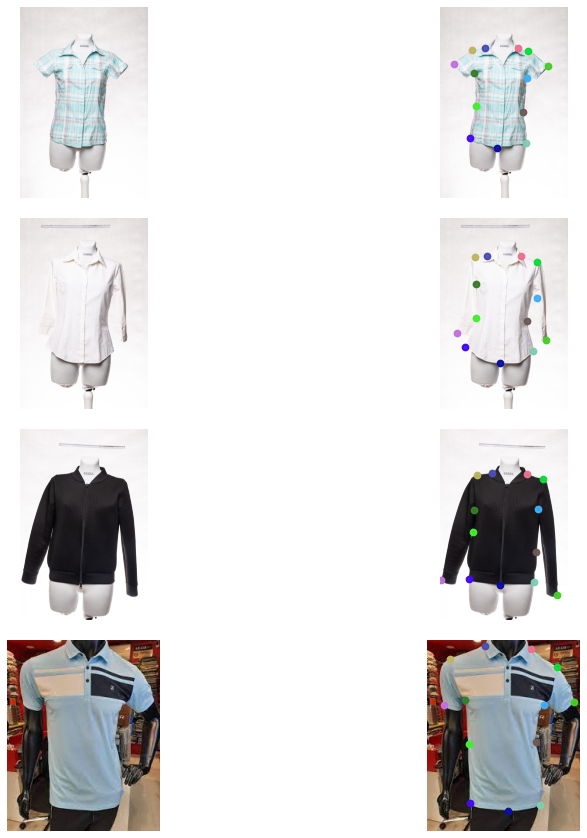

In [5]:
# Parts of this code come from here:
# https://github.com/benjiebob/StanfordExtra/blob/master/demo.ipynb
def visualize_keypoints(images, keypoints):
    fig, axes = plt.subplots(nrows=len(images), ncols=2, figsize=(16, 12))
    [ax.axis("off") for ax in np.ravel(axes)]

    for (ax_orig, ax_all), image, current_keypoint in zip(axes, images, keypoints):
        ax_orig.imshow(image)
        ax_all.imshow(image)

        # If the keypoints were formed by `imgaug` then the coordinates need
        # to be iterated differently.
        if isinstance(current_keypoint, KeypointsOnImage):
            for idx, kp in enumerate(current_keypoint.keypoints):
                ax_all.scatter(
                    [kp.x], [kp.y], c=colours[idx], marker="x", s=50, linewidths=5
                )
        else:
            current_keypoint = np.array(current_keypoint)
            for idx, el in enumerate(current_keypoint):
                ax_all.scatter(el[0], el[1], c=colours[idx], marker=".", s=30, linewidths=5)

    plt.tight_layout(pad=2.0)
    plt.show()


# Select four samples randomly for visualization.
samples = list(json_dict.keys())
num_samples = 4
selected_samples = np.random.choice(samples, num_samples, replace=False)

images, keypoints = [], []

for sample in selected_samples:
    data = get_img(sample)
    image = data["img_data"]
    keypoint = data["points"]

    images.append(image)
    keypoints.append(keypoint)

visualize_keypoints(images, keypoints)


In [6]:
class KeyPointsDataset(keras.utils.Sequence):
    def __init__(self, image_keys, aug, batch_size=BATCH_SIZE, train=True):
        self.image_keys = image_keys
        self.aug = aug
        self.batch_size = batch_size
        self.train = train
        self.on_epoch_end()

    def __len__(self):
        return len(self.image_keys) // self.batch_size

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.image_keys))
        if self.train:
            np.random.shuffle(self.indexes)

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]
        image_keys_temp = [self.image_keys[k] for k in indexes]
        (images, keypoints) = self.__data_generation(image_keys_temp)

        return (images, keypoints)

    def __data_generation(self, image_keys_temp):
        batch_images = np.empty((self.batch_size, IMG_SIZE, IMG_SIZE, 3), dtype="int")
        batch_keypoints = np.empty(
            (self.batch_size, 1, 1, NUM_KEYPOINTS), dtype="float32"
        )

        for i, key in enumerate(image_keys_temp):
            data = get_img_edge(key)
            current_keypoint = np.array(data["points"])
            kps = []

            # To apply our data augmentation pipeline, we first need to
            # form Keypoint objects with the original coordinates.
            for j in range(0, len(current_keypoint)):
                kps.append(Keypoint(x=current_keypoint[j][0], y=current_keypoint[j][1]))

            # We then project the original image and its keypoint coordinates.
            current_image = data["img_data"]
            kps_obj = KeypointsOnImage(kps, shape=current_image.shape)
            #print(kps_obj)
            # Apply the augmentation pipeline.
            (new_image, new_kps_obj) = self.aug(image=current_image, keypoints=kps_obj)
            batch_images[i,] = new_image

            #print(new_kps_obj)
            #print(new_image.shape)
            # Parse the coordinates from the new keypoint object.
            kp_temp = []
            for keypoint in new_kps_obj:
                kp_temp.append(np.nan_to_num(keypoint.x))
                kp_temp.append(np.nan_to_num(keypoint.y))
            #print(kp_temp)
            # More on why this reshaping later.
            batch_keypoints[i,] = np.array(kp_temp).reshape(1, 1, 13 * 2)
        # Scale the coordinates to [0, 1] range.
        batch_keypoints = batch_keypoints / IMG_SIZE

        return (batch_images, batch_keypoints)


In [7]:
train_aug = iaa.Sequential(
    [
        iaa.Resize(IMG_SIZE, interpolation="linear"),
        iaa.Fliplr(0.3),
        # `Sometimes()` applies a function randomly to the inputs with
        # a given probability (0.3, in this case).
        #iaa.Sometimes(0.3, iaa.Affine(rotate=10, scale=(0.5, 0.7))),
    ]
)

test_aug = iaa.Sequential([iaa.Resize(IMG_SIZE, interpolation="linear")])


In [8]:
np.random.shuffle(samples)
train_keys, validation_keys = (
    samples[int(len(samples) * 0.15) :],
    samples[: int(len(samples) * 0.15)],
)


Total batches in training set: 6
Total batches in validation set: 1


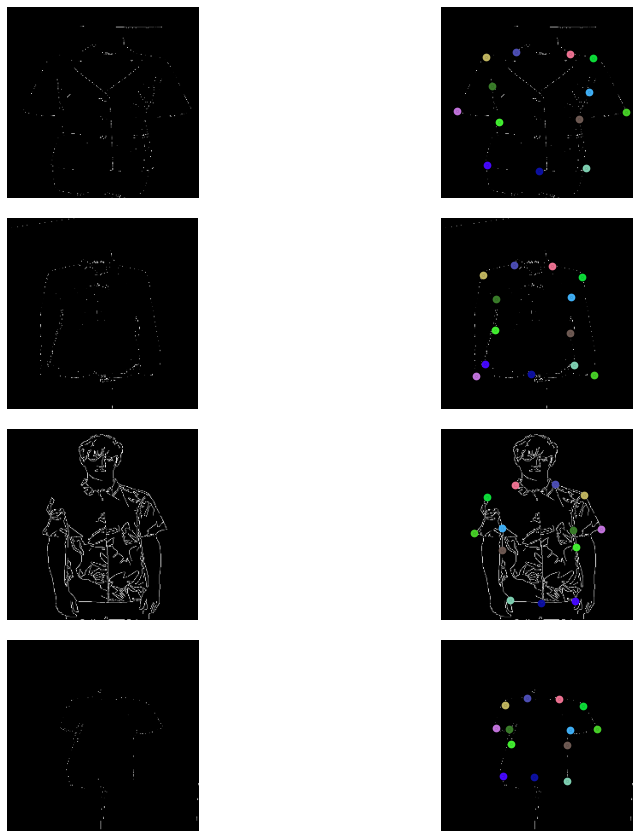

In [9]:
train_dataset = KeyPointsDataset(train_keys, train_aug)
validation_dataset = KeyPointsDataset(validation_keys, test_aug, train=False)

print(f"Total batches in training set: {len(train_dataset)}")
print(f"Total batches in validation set: {len(validation_dataset)}")

sample_images, sample_keypoints = next(iter(train_dataset))

assert sample_keypoints.max() <= 1.0
assert sample_keypoints.min() >= 0.0
sample_keypoints = sample_keypoints[:4].reshape(-1, 13, 2) * IMG_SIZE
visualize_keypoints(sample_images[:4], sample_keypoints)


In [10]:
def get_model():
    # Load the pre-trained weights of MobileNetV2 and freeze the weights
    backbone = keras.applications.MobileNetV2(
        weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )
    backbone.trainable = False

    inputs = layers.Input((IMG_SIZE, IMG_SIZE, 3))
    x = keras.applications.mobilenet_v2.preprocess_input(inputs)
    x = backbone(x)
    x = layers.Dropout(0.3)(x)
    x = layers.SeparableConv2D(
        NUM_KEYPOINTS, kernel_size=5, strides=1, activation="relu"
    )(x)
    outputs = layers.SeparableConv2D(
        NUM_KEYPOINTS, kernel_size=3, strides=1, activation="sigmoid"
    )(x)

    return keras.Model(inputs, outputs, name="keypoint_detector")


In [11]:
get_model().summary()


Model: "keypoint_detector"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 dropout (Dropout)           (None, 7, 7, 1280)        0         
                                                 

In [12]:
model = get_model()
model.compile(loss="mse", optimizer=keras.optimizers.Adam(1e-4))
model.fit(train_dataset, validation_data=validation_dataset, epochs=EPOCHS)


Epoch 1/100
6/6 [==============================] - 170s 29s/step - loss: 0.0481 - val_loss: 0.0500
Epoch 2/100
6/6 [==============================] - 89s 16s/step - loss: 0.0482 - val_loss: 0.0498
Epoch 3/100
6/6 [==============================] - 89s 17s/step - loss: 0.0491 - val_loss: 0.0496
Epoch 4/100
6/6 [==============================] - 55s 10s/step - loss: 0.0480 - val_loss: 0.0494
Epoch 5/100
6/6 [==============================] - 38s 7s/step - loss: 0.0484 - val_loss: 0.0492
Epoch 6/100
6/6 [==============================] - 108s 20s/step - loss: 0.0470 - val_loss: 0.0489
Epoch 7/100
6/6 [==============================] - 114s 22s/step - loss: 0.0479 - val_loss: 0.0487
Epoch 8/100
6/6 [==============================] - 55s 10s/step - loss: 0.0485 - val_loss: 0.0484
Epoch 9/100
6/6 [==============================] - 80s 15s/step - loss: 0.0471 - val_loss: 0.0481
Epoch 10/100
6/6 [==============================] - 21s 4s/step - loss: 0.0473 - val_loss: 0.0477
Epoch 11/100
6/6 [

6/6 [==============================] - 15s 3s/step - loss: 0.0229 - val_loss: 0.0135
Epoch 85/100
6/6 [==============================] - 15s 3s/step - loss: 0.0229 - val_loss: 0.0131
Epoch 86/100
6/6 [==============================] - 15s 3s/step - loss: 0.0218 - val_loss: 0.0129
Epoch 87/100
6/6 [==============================] - 15s 3s/step - loss: 0.0244 - val_loss: 0.0130
Epoch 88/100
6/6 [==============================] - 15s 2s/step - loss: 0.0252 - val_loss: 0.0135
Epoch 89/100
6/6 [==============================] - 16s 2s/step - loss: 0.0182 - val_loss: 0.0135
Epoch 90/100
6/6 [==============================] - 16s 3s/step - loss: 0.0218 - val_loss: 0.0131
Epoch 91/100
6/6 [==============================] - 15s 3s/step - loss: 0.0228 - val_loss: 0.0128
Epoch 92/100
6/6 [==============================] - 15s 3s/step - loss: 0.0203 - val_loss: 0.0129
Epoch 93/100
6/6 [==============================] - 14s 2s/step - loss: 0.0199 - val_loss: 0.0124
Epoch 94/100
6/6 [===============

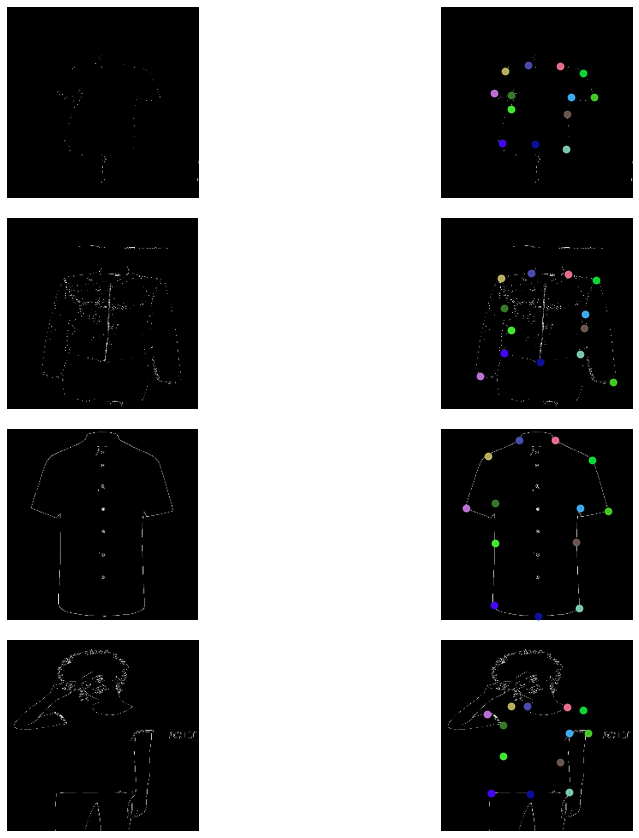

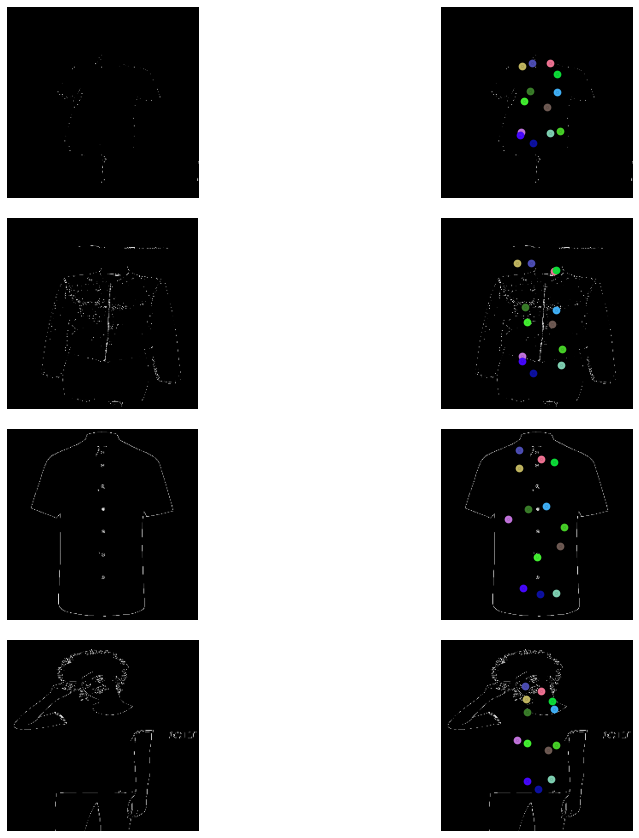

In [13]:
sample_val_images, sample_val_keypoints = next(iter(validation_dataset))
sample_val_images = sample_val_images[:4]
sample_val_keypoints = sample_val_keypoints[:4].reshape(-1, 13, 2) * IMG_SIZE
predictions = model.predict(sample_val_images).reshape(-1, 13, 2) * IMG_SIZE

# Ground-truth
visualize_keypoints(sample_val_images, sample_val_keypoints)

# Predictions
visualize_keypoints(sample_val_images, predictions)
